Incompressible Channel at Re=5200
=================================

+ Low-Mach (Mach is approximately 0.01)
+ Homogeneous in streamwise and spanwise directions

See https://turbulence.oden.utexas.edu/

How to postprocess data
-----------------------

Unlike the steady state regression tests, this case has time-varying data.  Therefore it is necessary to postprocess the saved fields to get the data needed for validation.

The steps to produce the post-processed data is listed in the post-processing repo, in the `channel_LM` folder, in the `README.md` file.  Once the post-processed data is generated, it can be copied over to this directory, in a new folder matching the correct commit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(('seaborn-notebook'))

In [2]:
def plot_log_layer_indicator(SU2, DNS, beta_DNS):
    hybrid_iterations = SU2["iterations"][1:]
    fig, ax = plt.subplots()
    x_limits = [30, 5200]
    rescaled_iterations = (np.array(hybrid_iterations) - hybrid_iterations[0])/(hybrid_iterations[-1] - hybrid_iterations[0])
    ax.set_prop_cycle('color', plt.cm.cool(rescaled_iterations))
    for i in range(len(hybrid_iterations)):
        time_label = "$t = {:.1f}$".format(SU2["time"][i+1])
        ax.plot(SU2["yplus"], SU2["beta"][i+1, :], label=time_label, linewidth=1, alpha=0.3)
    ax.set_prop_cycle(None)
    ax.plot(SU2["yplus"], SU2["beta"][0, :], label="RANS")
    ax.plot(SU2["yplus"], SU2["mean_beta"], label="mean")
    ax.plot(x_limits, 1.0/0.4 * np.ones(2), "--", label="$1/\\kappa$")
    ax.plot(DNS_mean["yplus"], beta_DNS, label="DNS")
    ax.set_xlim(x_limits)
    ax.set_xscale("log")
    ax.set_ylim([2, 4])
    ax.set_ylabel("$\\frac{1}{y^+} \\frac{\partial u^+}{\partial y^+}$")
    ax.set_xlabel("$y+$")
    ax.legend(loc="best")
    fig.set_size_inches(10, 5)
    fig.tight_layout()
    return fig, ax

Extract Data
------------

In [3]:
iterations = [22000, 24000, 26000, 27000, 28000, 28500, 29000, 29500, 30000, 30500, 31000]
# Note: If the dimensional timestep is from SU2, then the dimensional
# length and dimensional bulk velocity must also be from SU2
L = 2*np.pi
U_b = 24.31133907641122
flow_through_time = L/U_b
timestep = 5e-4
nondim_times = [(it - iterations[0])*timestep*U_b/L for it in iterations]
dx = 0.06346651825434
CFL = timestep*U_b/dx
print(CFL)

0.19152885446610068


In [4]:
names = ['y', 'yplus', 'u']
columns = [0, 1, 2]
DNS_mean = np.genfromtxt("DNS_data/LM_Channel_5200_mean_prof.dat", skip_header=72, usecols=columns, names=names)
names = ['y', 'yplus', 'v2', 'TKE']
columns = [0, 1, 3, 8]
DNS_velfluc = np.genfromtxt("DNS_data/LM_Channel_5200_vel_fluc_prof.dat", skip_header=75, usecols=columns, names=names)
DNS_beta = DNS_mean["yplus"]*np.gradient(DNS_mean["u"], DNS_mean["yplus"])

In [5]:
commits = ['acb8693', 'ccf0f88']
SU2_data = {}
for commit in commits:
    SU2_data[commit] = {}
    for iteration in iterations:
        infile = commit + "/nondim_" + str(iteration) + ".npz"
        SU2_data[commit][str(iteration)] = np.load(infile)

In [6]:
stationary_iters = [28000, 28500, 29000, 29500, 30000, 30500, 31000]
stationary_times = [(it - iterations[0])*timestep*U_b/L for it in stationary_iters]
stationary_label = "Average of {:.1f} to {:.1f} flow-throughs".format(stationary_times[0], stationary_times[-1])

In [7]:
for commit in commits:
    SU2_data[commit]["mean"] = {}
    SU2_data[commit]["std"] = {}
    for key in SU2_data[commit][str(iterations[0])]:
        stationary_data = [SU2_data[commit][str(iteration)][key] for iteration in stationary_iters]
        SU2_data[commit]["mean"][key] = np.mean(stationary_data, axis=0)
        SU2_data[commit]["std"][key] = np.std(stationary_data, axis=0)

Mean Velocity
-------------

In [8]:
xlimits = [0.5, np.max(DNS_mean['yplus'])]

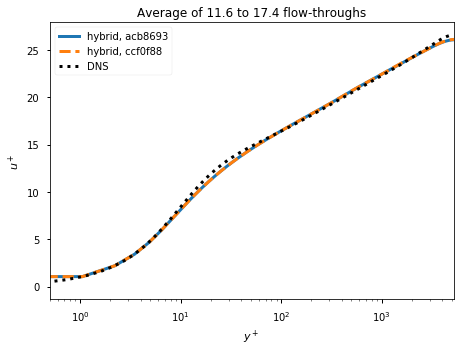

In [9]:
symbols = ["-", "--", ":"]
fig, ax = plt.subplots()
for commit, symbol in zip(commits, symbols): 
    ax.semilogx(SU2_data[commit]["mean"]["yplus"], SU2_data[commit]["mean"]["u"],
                symbol, label=("hybrid, " + commit), linewidth=3)
ax.semilogx(DNS_mean["yplus"], DNS_mean["u"], ":k", label="DNS", linewidth=3)
ax.legend(loc="best")
ax.set_xlim(xlimits)
ax.set_ylabel("$u^+$")
ax.set_xlabel("$y^+$")
ax.set_title(stationary_label)
fig.set_size_inches([6.5, 5])
fig.tight_layout()
fig.savefig("lowmach_uplus.pdf", transparent=True)

Log-Layer Indicator
-------------------

In [10]:
SU2_loglayer = {}
for commit in commits:
    SU2_loglayer[commit] = np.load(commit + "/log_layer_indicator.npz")

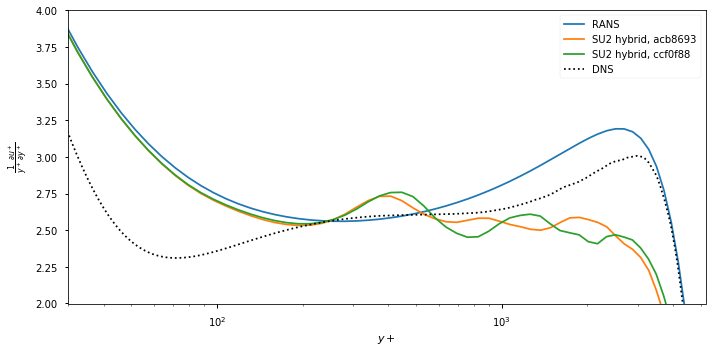

In [11]:
fig, ax = plt.subplots()
ax.plot(SU2_loglayer[commits[0]]["yplus"], SU2_loglayer[commits[0]]["beta"][0,:], label="RANS")
for commit in commits:
    label = "SU2 hybrid, " + commit
    ax.plot(SU2_loglayer[commit]["yplus"], SU2_loglayer[commit]["mean_beta"], label=label)
ax.plot(DNS_mean["yplus"], DNS_beta, "k:", label="DNS")
ax.set_xlim([30, 5200])
ax.set_xscale("log")
ax.set_ylim([2, 4])
ax.set_ylabel("$\\frac{1}{y^+} \\frac{\partial u^+}{\partial y^+}$")
ax.set_xlabel("$y+$")
ax.legend(loc="best")
fig.set_size_inches(10, 5)
fig.tight_layout()
fig.savefig("lowmach_log_layer.pdf", transparent=True)

TKE
---

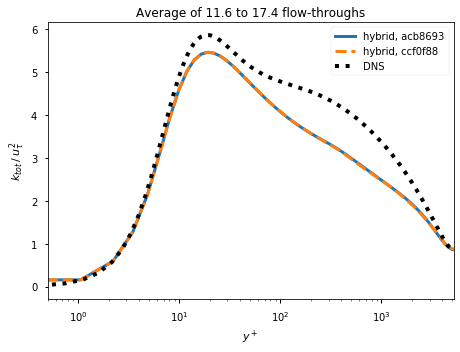

In [12]:
fig, ax = plt.subplots()
for commit, symbol in zip(commits, symbols): 
    ax.semilogx(SU2_data[commit]["mean"]["yplus"], SU2_data[commit]["mean"]["TKE"],
                symbol, label=("hybrid, " + commit), linewidth=3)
ax.semilogx(DNS_velfluc["yplus"], DNS_velfluc["TKE"], ":k", label="DNS", linewidth=4)
ax.legend(loc="best")
ax.set_xlim(xlimits)
ax.set_ylabel("$k_{tot}\:/\:u_{\\tau}^2$")
ax.set_xlabel("$y^+$")
ax.set_title(stationary_label)
fig.set_size_inches([6.5, 5])
fig.tight_layout()
fig.savefig("lowmach_tke.pdf", transparent=True)

Alpha
-----

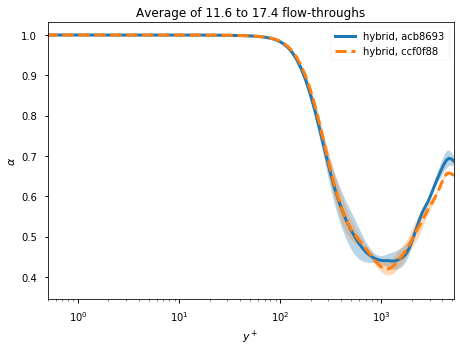

In [13]:
fig, ax = plt.subplots()
for commit, symbol in zip(commits, symbols): 
    ax.semilogx(SU2_data[commit]["mean"]["yplus"], SU2_data[commit]["mean"]["alpha"],
                symbol, label=("hybrid, " + commit), linewidth=3)
    upper_limit = SU2_data[commit]["mean"]["alpha"] + SU2_data[commit]["std"]["alpha"]
    lower_limit = SU2_data[commit]["mean"]["alpha"] - SU2_data[commit]["std"]["alpha"]
    ax.fill_between(SU2_data[commit]["mean"]["yplus"], lower_limit, upper_limit, alpha=0.3)
ax.legend(loc="best")
ax.set_xlim(xlimits)
ax.set_ylabel("$\\alpha$")
ax.set_xlabel("$y^+$")
ax.set_title(stationary_label)
fig.set_size_inches([6.5, 5])
fig.tight_layout()
fig.savefig("lowmach_alpha.pdf", transparent=True)

Time Evolution
--------------

In [14]:
time_data = {}
for commit in commits:
    time_data[commit] = np.load(commit + "/time_evolution.npz")
    y_indices = [50, 74]

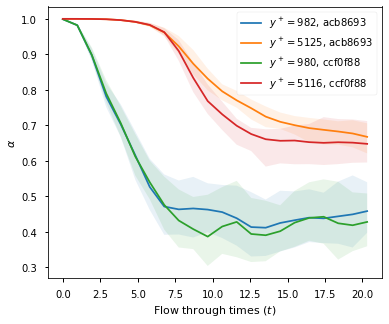

In [15]:
fig, ax = plt.subplots()
for commit in commits:
    SU2 = time_data[commit]
    for y_index in y_indices:
        y_loc = SU2["yplus"][y_index]
        label="$y^+ = {:.0f}$, {}".format(y_loc, commit)
        ax.plot(SU2["time"], SU2["alpha"]["mean"][:, y_index], label=label)
        ax.fill_between(SU2["time"], SU2["alpha"]["p75"][:, y_index],
                         SU2["alpha"]["p25"][:, y_index], alpha=0.1)
ax.legend(loc="best")
ax.set_xlabel("Flow through times ($t$)")
ax.set_ylabel("$\\alpha$")
fig.set_size_inches(6, 5)
plt.show()

In [ ]:
fig, ax = plt.subplots()
for commit in commits:
    SU2 = time_data[commit]
    for y_index in y_indices:
        y_loc = SU2["yplus"][y_index]
        label="$y^+ = {:.0f}$, {}".format(y_loc, commit)
        ax.plot(SU2["time"][1:], SU2["r_M"]["median"][1:, y_index], label=label)
        ax.fill_between(SU2["time"][1:], SU2["r_M"]["p75"][1:, y_index],
                         SU2["r_M"]["p25"][1:, y_index], alpha=0.1)
ax.legend(loc="best")
ax.set_xlabel("Flow through times ($t$)")
ax.set_ylabel("$r_M$")
fig.set_size_inches(6, 5)
plt.show()

In [ ]:
fig, ax = plt.subplots()
for commit in commits:
    SU2 = time_data[commit]
    for y_index in y_indices:
        y_loc = SU2["yplus"][y_index]
        label="$y^+ = {:.0f}$, {}".format(y_loc, commit)
        ax.plot(SU2["time"][1:], SU2["F_mag"]["mean"][1:, y_index], label=label)
        ax.fill_between(SU2["time"][1:], SU2["F_mag"]["p75"][1:, y_index],
                         SU2["F_mag"]["p25"][1:, y_index], alpha=0.1)
ax.legend(loc="best")
ax.set_xlabel("Flow through times ($t$)")
ax.set_ylabel("$||F||h/u_{\\tau}^2$")
fig.set_size_inches(6, 5)
plt.show()